# Baseline vs Best 100K Model Comparison

**Models compared:**
- **Baseline**: Moirai2 Small, 100K steps, no preconditioning (Normalized MASE 0.921)
- **Best 100K**: Moirai2 Small + Chebyshev d=4 hint + 10% hint dropout, 100K steps (Normalized MASE 0.853)

**Checkpoints:**
```
Baseline:  /scratch/gpfs/EHAZAN/jh1161/uni2ts/outputs/pretrain/moirai2_small/lotsa_v1_unweighted/m2_baseline_20260209_114203/checkpoints/epoch_999-step_100000.ckpt
Best 100K: /scratch/gpfs/EHAZAN/jh1161/uni2ts/outputs/pretrain/moirai2_small/lotsa_v1_unweighted/m2_hd10_100k_20260223_112829/checkpoints/epoch_999-step_100000.ckpt
```

**Evaluation settings** (identical for both): context_length=4000, patch_size=32, batch_size=64, 97 GIFT-Eval configs.

**Training note:** Baseline uses 10K warmup steps; hint model uses 1K warmup steps. Both use cosine annealing, AdamW (lr=1e-3), 100K total steps (1000 epochs x 100 batches, bs=256) on LOTSA v1.

**MASE normalization:** All MASE numbers in this notebook are **normalized by the Seasonal Naive model's MASE per config**, consistent with the [GIFT-Eval leaderboard](https://huggingface.co/spaces/Salesforce/GIFT-Eval). A normalized MASE of 0.80 means the model's error is 80% of the seasonal naive model's error. Lower is better.

**Data files** (all in this folder):
- `baseline_100k_eval.csv` — GIFT-Eval results for baseline (from `gifteval/results/gifteval_results_epoch_999-step_100000_20260210_203632.csv`)
- `hd10_100k_eval.csv` — GIFT-Eval results for hint+dropout model (from `gifteval/results/gifteval_results_epoch_999-step_100000_20260223_235237.csv`)
- `training_loss_data.json` — Training loss curves extracted from TensorBoard event files

In [ ]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gmean

plt.rcParams.update({
    'figure.figsize': (12, 5),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

# Load training loss data extracted from TensorBoard
with open("training_loss_data.json") as f:
    tb_data = json.load(f)

# Load evaluation CSVs (local copies, both eval'd with context=4000, patch=32)
baseline_eval = pd.read_csv("baseline_100k_eval.csv")
hd10_eval = pd.read_csv("hd10_100k_eval.csv")

# --- Normalize MASE by Seasonal Naive (consistent with GIFT-Eval leaderboard) ---
# Load seasonal naive reference results from the official GIFT-Eval repo
sn_df = pd.read_csv("/scratch/gpfs/EHAZAN/jh1161/gifteval/gift-eval/results/seasonal_naive/all_results.csv")
sn_mase = dict(zip(sn_df['dataset'].str.lower().values, sn_df['eval_metrics/MASE[0.5]'].values))

# Pretty names used by the leaderboard
pretty_names = {
    'saugeenday': 'saugeen',
    'temperature_rain_with_missing': 'temperature_rain',
    'kdd_cup_2018_with_missing': 'kdd_cup_2018',
    'car_parts_with_missing': 'car_parts',
}

def normalize_config(config_str):
    """Convert our config_name format to match the seasonal naive reference format."""
    parts = config_str.split('/')
    # Fix duplicated frequency: a/b/b/c -> a/b/c
    if len(parts) == 4 and parts[1] == parts[2]:
        parts = [parts[0], parts[1], parts[3]]
    # Fix 4-part with day anchor: a/b/b-DAY/c -> a/b/c
    if len(parts) == 4:
        parts = [parts[0], parts[1], parts[3]]
    # Apply pretty names
    if len(parts) >= 1:
        ds_name = parts[0].lower()
        ds_name = pretty_names.get(ds_name, ds_name)
        parts[0] = ds_name
    # Strip day anchors from frequency: W-FRI -> W, Q-DEC -> Q, A-DEC -> A
    if len(parts) >= 2:
        parts[1] = re.sub(r'-.*', '', parts[1])
    return '/'.join(parts).lower()

def add_normalized_mase(df, mase_col='MASE', config_col='config_name'):
    """Add a 'norm_MASE' column: MASE divided by seasonal naive MASE for each config."""
    norm_vals = []
    for _, row in df.iterrows():
        config = normalize_config(str(row[config_col]))
        sn_val = sn_mase.get(config, np.nan)
        norm_vals.append(row[mase_col] / sn_val if not np.isnan(sn_val) else np.nan)
    df['norm_MASE'] = norm_vals
    return df

baseline_eval = add_normalized_mase(baseline_eval)
hd10_eval = add_normalized_mase(hd10_eval)

matched_b = baseline_eval['norm_MASE'].notna().sum()
matched_h = hd10_eval['norm_MASE'].notna().sum()

print(f"Baseline eval: {len(baseline_eval)} configs, {matched_b} matched to seasonal naive")
print(f"HD10 eval:     {len(hd10_eval)} configs, {matched_h} matched to seasonal naive")
print(f"\nBaseline normalized MASE (geo mean): {gmean(baseline_eval['norm_MASE'].dropna()):.4f}")
print(f"HD10 normalized MASE (geo mean):     {gmean(hd10_eval['norm_MASE'].dropna()):.4f}")
print(f"\n(For reference, official Moirai 2.0-R-small = 0.728 on leaderboard)")

## 1. Architecture Comparison

### Baseline: Standard Moirai2 Small

The baseline is a **causal decoder-only transformer** for time series forecasting:

| Component | Details |
|-----------|---------|
| **d_model** | 384 |
| **d_ff** | 1024 |
| **Layers** | 6 attention layers |
| **Patch size** | 16 (each patch = 16 time steps) |
| **Parameters** | 11.39M |
| **Loss** | PackedQuantileMAELoss (pinball loss over 9 quantiles) |
| **Scaler** | Per-series z-score normalization |

**Input representation per patch**: `[target (16), observation_mask (16)]` = 32 dims, projected to 384 via `in_proj`.

### Best 100K: Moirai2 Small + Preconditioning Hint

The hint model adds **one extra input channel** per patch containing the preconditioning filter residual:

| Component | Details |
|-----------|---------|
| **Architecture** | Same 6-layer causal transformer |
| **Parameters** | 11.40M (+12K for wider `in_proj`: 48 -> 384 instead of 32 -> 384) |
| **Hint channel** | Chebyshev degree-4 preconditioning filter residual at stride 16 |
| **Hint dropout** | 10% (per-patch, training only) |

**Input representation per patch**: `[target (16), observation_mask (16), hint_d4 (16)]` = 48 dims, projected to 384.

The hint channel computes a **causal preconditioning filter residual** (technically a Finite Impulse Response / FIR filter):
```
hint[t] = -1.0 * y[t-32] + 0.125 * y[t-64]
```
This tells the model "how does this time step relate to the same position in previous patches" -- providing explicit inter-patch autocorrelation information. The hint is zeroed in the prediction window (future values unknown).

In [ ]:
# Visualize the architecture difference
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline input
ax = axes[0]
ax.set_title("Baseline: Input per Patch")
bars = ax.barh(["target\n(16 values)", "obs_mask\n(16 values)"], [16, 16],
               color=["#4C72B0", "#55A868"], height=0.5)
ax.set_xlabel("Dimensions")
ax.set_xlim(0, 20)
ax.axvline(x=16, color='gray', linestyle='--', alpha=0.5)
ax.text(8, -0.6, "in_proj: 32 -> 384", ha='center', fontsize=11, style='italic')
ax.set_title("Baseline Input (32 dims/patch)", fontweight='bold')

# Preconditioned hint model input
ax = axes[1]
ax.set_title("Preconditioned Hint Model: Input per Patch")
bars = ax.barh(["target\n(16 values)", "obs_mask\n(16 values)", "precond_hint\n(16 values)"],
               [16, 16, 16],
               color=["#4C72B0", "#55A868", "#C44E52"], height=0.5)
ax.set_xlabel("Dimensions")
ax.set_xlim(0, 20)
ax.axvline(x=16, color='gray', linestyle='--', alpha=0.5)
ax.text(8, -0.6, "in_proj: 48 -> 384", ha='center', fontsize=11, style='italic')
ax.set_title("Preconditioned Hint Input (48 dims/patch)", fontweight='bold')

plt.tight_layout()
plt.savefig("architecture_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 2. Training Loss Comparison

Both models are trained for 100K steps (1000 epochs x 100 batches/epoch, batch_size=256) on LOTSA v1.

The training loss is `PackedQuantileMAELoss` -- pinball loss over 9 quantile levels (0.1 to 0.9). This is the same loss function for both models; the only difference is what inputs the model receives.

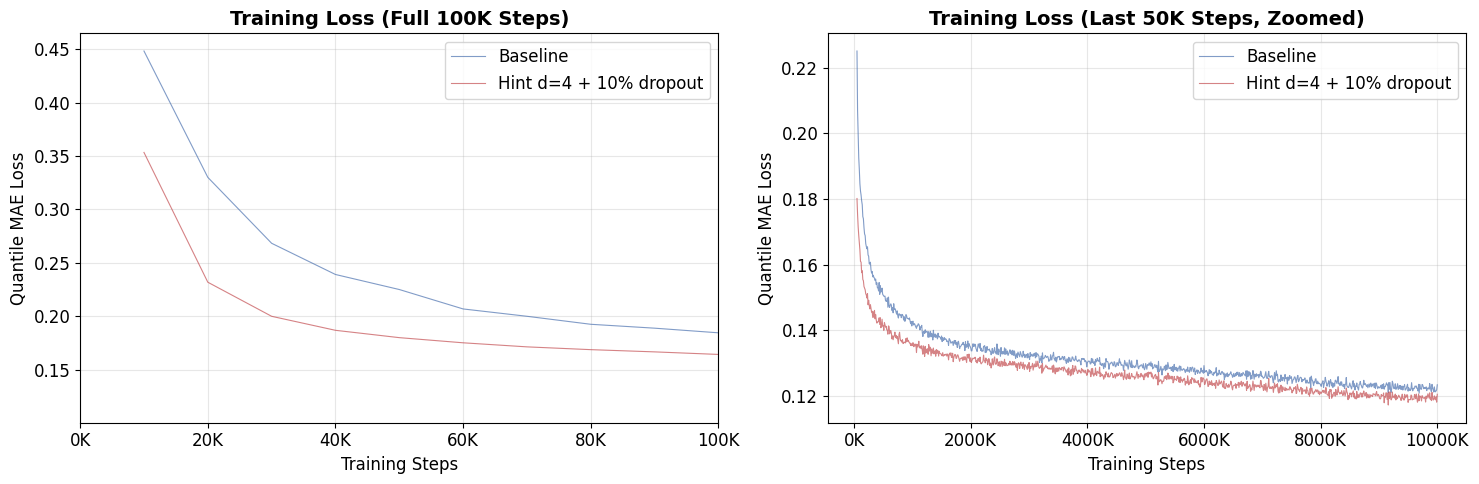


Baseline:  first epoch loss = 0.4482, final epoch loss = 0.1233
Hint d=4:  first epoch loss = 0.3534, final epoch loss = 0.1204

Delta at final epoch: -0.0029 (-2.4%)


In [3]:
# Extract epoch-level training losses (1 point per epoch = 1 point per 100 steps)
baseline_loss = tb_data["baseline"]["train/total_loss_epoch"]
hd10_loss = tb_data["hd10"]["train/total_loss_epoch"]

baseline_steps = np.array(baseline_loss["steps"])  # epoch indices
baseline_vals = np.array(baseline_loss["values"])
hd10_steps = np.array(hd10_loss["steps"])
hd10_vals = np.array(hd10_loss["values"])

# Convert epoch to steps (100 steps per epoch)
baseline_steps_real = (baseline_steps + 1) * 100
hd10_steps_real = (hd10_steps + 1) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Full training curve
ax = axes[0]
ax.plot(baseline_steps_real, baseline_vals, alpha=0.7, label='Baseline', color='#4C72B0', linewidth=0.8)
ax.plot(hd10_steps_real, hd10_vals, alpha=0.7, label='Hint d=4 + 10% dropout', color='#C44E52', linewidth=0.8)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Quantile MAE Loss')
ax.set_title('Training Loss (Full 100K Steps)', fontweight='bold')
ax.legend()
ax.set_xlim(0, 100000)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
ax.grid(True, alpha=0.3)

# Zoomed in: last 50K steps
ax = axes[1]
mask_b = baseline_steps_real >= 50000
mask_h = hd10_steps_real >= 50000
ax.plot(baseline_steps_real[mask_b], baseline_vals[mask_b], alpha=0.7,
        label='Baseline', color='#4C72B0', linewidth=0.8)
ax.plot(hd10_steps_real[mask_h], hd10_vals[mask_h], alpha=0.7,
        label='Hint d=4 + 10% dropout', color='#C44E52', linewidth=0.8)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Quantile MAE Loss')
ax.set_title('Training Loss (Last 50K Steps, Zoomed)', fontweight='bold')
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_loss_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBaseline:  first epoch loss = {baseline_vals[0]:.4f}, final epoch loss = {baseline_vals[-1]:.4f}")
print(f"Hint d=4:  first epoch loss = {hd10_vals[0]:.4f}, final epoch loss = {hd10_vals[-1]:.4f}")
print(f"\nDelta at final epoch: {hd10_vals[-1] - baseline_vals[-1]:.4f} ({(hd10_vals[-1]/baseline_vals[-1] - 1)*100:.1f}%)")

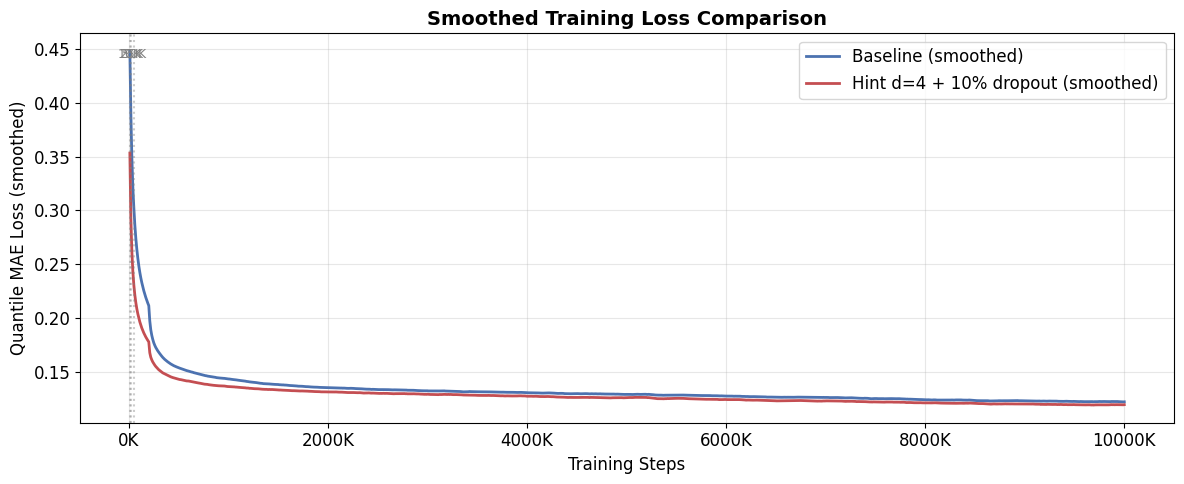

In [4]:
# Smoothed training loss (rolling window)
window = 20  # 20 epochs = 2000 steps

def smooth(vals, w):
    return pd.Series(vals).rolling(w, min_periods=1).mean().values

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(baseline_steps_real, smooth(baseline_vals, window), 
        label='Baseline (smoothed)', color='#4C72B0', linewidth=2)
ax.plot(hd10_steps_real, smooth(hd10_vals, window),
        label='Hint d=4 + 10% dropout (smoothed)', color='#C44E52', linewidth=2)

# Mark key milestones
for step, label in [(10000, '10K'), (25000, '25K'), (50000, '50K')]:
    ax.axvline(x=step, color='gray', linestyle=':', alpha=0.4)
    ax.text(step, ax.get_ylim()[1]*0.95, label, ha='center', fontsize=9, color='gray')

ax.set_xlabel('Training Steps')
ax.set_ylabel('Quantile MAE Loss (smoothed)')
ax.set_title('Smoothed Training Loss Comparison', fontweight='bold')
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("training_loss_smoothed.png", dpi=150, bbox_inches='tight')
plt.show()

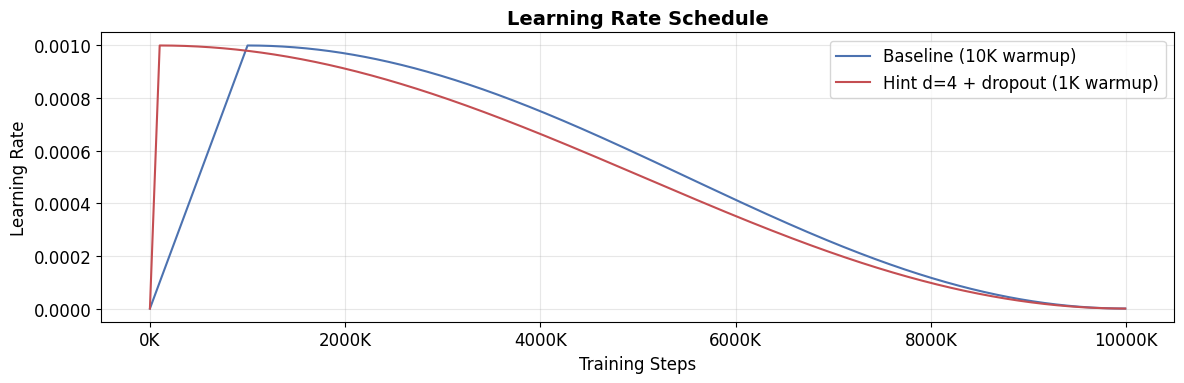

Note: Baseline uses 10K warmup steps, hint model uses 1K warmup steps.
Both use cosine annealing after warmup.


In [5]:
# Learning rate schedules
baseline_lr = tb_data["baseline"]["lr-AdamW/pg2"]
hd10_lr = tb_data["hd10"]["lr-AdamW/pg2"]

fig, ax = plt.subplots(figsize=(12, 4))
# LR is logged per epoch
baseline_lr_steps = (np.array(baseline_lr["steps"]) + 1) * 100
hd10_lr_steps = (np.array(hd10_lr["steps"]) + 1) * 100

ax.plot(baseline_lr_steps, baseline_lr["values"],
        label='Baseline (10K warmup)', color='#4C72B0', linewidth=1.5)
ax.plot(hd10_lr_steps, hd10_lr["values"],
        label='Hint d=4 + dropout (1K warmup)', color='#C44E52', linewidth=1.5)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule', fontweight='bold')
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Note: Baseline uses 10K warmup steps, hint model uses 1K warmup steps.")
print("Both use cosine annealing after warmup.")

## 3. GIFT-Eval Results Comparison

GIFT-Eval is a comprehensive time series forecasting benchmark with 97 configurations across multiple datasets, frequencies (from 10-second to yearly), and forecast horizons (short/medium/long).

**Primary metric**: Normalized MASE — each config's MASE is divided by the Seasonal Naive model's MASE for that config (consistent with the [GIFT-Eval leaderboard](https://huggingface.co/spaces/Salesforce/GIFT-Eval)). Normalized MASE < 1.0 means the model beats the seasonal naive model.

In [ ]:
# Merge the two evaluation results on config_name
merged = baseline_eval.merge(
    hd10_eval,
    on="config_name",
    suffixes=("_baseline", "_hd10"),
    how="inner"
)

# Compute improvement (using normalized MASE — percentages are identical to raw)
merged["mase_improvement"] = (merged["norm_MASE_baseline"] - merged["norm_MASE_hd10"]) / merged["norm_MASE_baseline"] * 100
merged["mase_ratio"] = merged["norm_MASE_hd10"] / merged["norm_MASE_baseline"]

# Summary stats (normalized MASE)
geo_mean_baseline = gmean(merged["norm_MASE_baseline"].dropna())
geo_mean_hd10 = gmean(merged["norm_MASE_hd10"].dropna())
wins = (merged["norm_MASE_hd10"] < merged["norm_MASE_baseline"]).sum()
losses = (merged["norm_MASE_hd10"] > merged["norm_MASE_baseline"]).sum()
baseline_beats_naive = (merged["norm_MASE_baseline"] < 1.0).sum()
hd10_beats_naive = (merged["norm_MASE_hd10"] < 1.0).sum()

print("=" * 60)
print("GIFT-Eval Summary (97 configurations, normalized MASE)")
print("=" * 60)
print(f"{'Metric':<35} {'Baseline':>10} {'Hint+Drop':>10}")
print("-" * 60)
print(f"{'Geo Mean norm MASE':<35} {geo_mean_baseline:>10.4f} {geo_mean_hd10:>10.4f}")
print(f"{'Arith Mean norm MASE':<35} {merged['norm_MASE_baseline'].mean():>10.4f} {merged['norm_MASE_hd10'].mean():>10.4f}")
print(f"{'Median norm MASE':<35} {merged['norm_MASE_baseline'].median():>10.4f} {merged['norm_MASE_hd10'].median():>10.4f}")
print(f"{'Configs < 1.0 (beat SN model)':<35} {baseline_beats_naive:>10d} {hd10_beats_naive:>10d}")
print(f"{'Min norm MASE':<35} {merged['norm_MASE_baseline'].min():>10.4f} {merged['norm_MASE_hd10'].min():>10.4f}")
print(f"{'Max norm MASE':<35} {merged['norm_MASE_baseline'].max():>10.4f} {merged['norm_MASE_hd10'].max():>10.4f}")
print("-" * 60)
print(f"{'Hint wins / losses':<35} {wins:>4d} / {losses:>4d}")
print(f"{'Relative improvement (geo mean)':<35} {(1 - geo_mean_hd10/geo_mean_baseline)*100:>9.2f}%")

In [ ]:
# Scatter plot: Baseline vs Hint normalized MASE per config
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: scatter
ax = axes[0]
ax.scatter(merged["norm_MASE_baseline"], merged["norm_MASE_hd10"], alpha=0.6, s=30, c='#4C72B0', edgecolors='white', linewidth=0.5)
max_val = max(merged["norm_MASE_baseline"].max(), merged["norm_MASE_hd10"].max()) * 1.05
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.4, linewidth=1, label='y = x (equal)')
ax.set_xlabel('Baseline Normalized MASE')
ax.set_ylabel('Hint d=4 + dropout Normalized MASE')
ax.set_title('Per-Config Normalized MASE Comparison', fontweight='bold')
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
ax.legend()
ax.grid(True, alpha=0.3)
# Count points below/above diagonal
ax.text(0.05, 0.95, f'Hint wins: {wins}\nBaseline wins: {losses}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right: improvement histogram
ax = axes[1]
improvements = merged["mase_improvement"].clip(-50, 80)
ax.hist(improvements, bins=40, color='#55A868', edgecolor='white', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=improvements.median(), color='red', linestyle='--', linewidth=1.5,
           label=f'Median: {merged["mase_improvement"].median():.1f}%')
ax.set_xlabel('Normalized MASE Improvement (%)')
ax.set_ylabel('Number of Configs')
ax.set_title('Distribution of Per-Config Improvements', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("eval_comparison_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Breakdown by frequency (using normalized MASE)
freq_col_b = "frequency_baseline"
freq_col_h = "frequency_hd10"

freq_results = []
for freq in sorted(merged[freq_col_b].unique()):
    mask = merged[freq_col_b] == freq
    sub = merged[mask]
    geo_b = gmean(sub["norm_MASE_baseline"].dropna())
    geo_h = gmean(sub["norm_MASE_hd10"].dropna())
    freq_results.append({
        "Frequency": freq,
        "N": len(sub),
        "Geo norm MASE (Baseline)": geo_b,
        "Geo norm MASE (Hint+Drop)": geo_h,
        "Improvement (%)": (1 - geo_h / geo_b) * 100,
        "Wins": (sub["norm_MASE_hd10"] < sub["norm_MASE_baseline"]).sum(),
        "Losses": (sub["norm_MASE_hd10"] > sub["norm_MASE_baseline"]).sum(),
    })

freq_df = pd.DataFrame(freq_results).sort_values("Improvement (%)", ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#55A868' if x > 0 else '#C44E52' for x in freq_df["Improvement (%)"]]
bars = ax.bar(range(len(freq_df)), freq_df["Improvement (%)"], color=colors, edgecolor='white')
ax.set_xticks(range(len(freq_df)))
ax.set_xticklabels([f'{r["Frequency"]}\n(n={r["N"]})' for _, r in freq_df.iterrows()], fontsize=10)
ax.set_ylabel('Normalized MASE Improvement (%)')
ax.set_title('Improvement by Data Frequency', fontweight='bold')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')

for i, (_, row) in enumerate(freq_df.iterrows()):
    ax.text(i, row["Improvement (%)"] + 0.5 * np.sign(row["Improvement (%)"]),
            f'{row["Improvement (%)"]:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig("eval_by_frequency.png", dpi=150, bbox_inches='tight')
plt.show()

print(freq_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

In [ ]:
# Breakdown by forecast horizon (using normalized MASE)
term_results = []
for term in ["short", "medium", "long"]:
    mask = merged["term_baseline"] == term
    sub = merged[mask]
    if len(sub) == 0:
        continue
    geo_b = gmean(sub["norm_MASE_baseline"].dropna())
    geo_h = gmean(sub["norm_MASE_hd10"].dropna())
    term_results.append({
        "Horizon": term,
        "N": len(sub),
        "Geo norm MASE (Baseline)": geo_b,
        "Geo norm MASE (Hint+Drop)": geo_h,
        "Improvement (%)": (1 - geo_h / geo_b) * 100,
        "Wins": (sub["norm_MASE_hd10"] < sub["norm_MASE_baseline"]).sum(),
        "Losses": (sub["norm_MASE_hd10"] > sub["norm_MASE_baseline"]).sum(),
    })

term_df = pd.DataFrame(term_results)

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(term_df))
w = 0.35
ax.bar([i - w/2 for i in x], term_df["Geo norm MASE (Baseline)"], w,
       label='Baseline', color='#4C72B0', edgecolor='white')
ax.bar([i + w/2 for i in x], term_df["Geo norm MASE (Hint+Drop)"], w,
       label='Hint d=4 + dropout', color='#C44E52', edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels([f'{r["Horizon"]}\n(n={r["N"]})' for _, r in term_df.iterrows()])
ax.set_ylabel('Geometric Mean Normalized MASE')
ax.set_title('Normalized MASE by Forecast Horizon', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i, (_, row) in enumerate(term_df.iterrows()):
    ax.text(i + w/2, row["Geo norm MASE (Hint+Drop)"] + 0.02,
            f'-{row["Improvement (%)"]:.1f}%', ha='center', fontsize=10, fontweight='bold', color='#C44E52')

plt.tight_layout()
plt.savefig("eval_by_horizon.png", dpi=150, bbox_inches='tight')
plt.show()

print(term_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

In [ ]:
# Top 15 biggest improvements and worst 10 regressions (normalized MASE)
print("=" * 80)
print("TOP 15 BIGGEST IMPROVEMENTS (Hint+Dropout over Baseline)")
print("=" * 80)
top_improve = merged.nlargest(15, "mase_improvement")[
    ["config_name", "norm_MASE_baseline", "norm_MASE_hd10", "mase_improvement"]
].copy()
top_improve.columns = ["Config", "Baseline norm MASE", "Hint+Drop norm MASE", "Improvement (%)"]
print(top_improve.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\n" + "=" * 80)
print("TOP 10 WORST REGRESSIONS")
print("=" * 80)
worst = merged.nsmallest(10, "mase_improvement")[
    ["config_name", "norm_MASE_baseline", "norm_MASE_hd10", "mase_improvement"]
].copy()
worst.columns = ["Config", "Baseline norm MASE", "Hint+Drop norm MASE", "Improvement (%)"]
print(worst.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

In [ ]:
# Per-dataset grouped bar chart (using normalized MASE)
dataset_results = []
for dataset in sorted(merged["dataset_baseline"].unique()):
    mask = merged["dataset_baseline"] == dataset
    sub = merged[mask]
    geo_b = gmean(sub["norm_MASE_baseline"].dropna())
    geo_h = gmean(sub["norm_MASE_hd10"].dropna())
    dataset_results.append({
        "Dataset": dataset,
        "N": len(sub),
        "Baseline": geo_b,
        "Hint+Drop": geo_h,
        "Improvement": (1 - geo_h / geo_b) * 100,
    })

ds_df = pd.DataFrame(dataset_results).sort_values("Improvement", ascending=True)

fig, ax = plt.subplots(figsize=(14, 8))
y = range(len(ds_df))
colors = ['#55A868' if x > 0 else '#C44E52' for x in ds_df["Improvement"]]
ax.barh(y, ds_df["Improvement"], color=colors, edgecolor='white', height=0.7)
ax.set_yticks(y)
ax.set_yticklabels(ds_df["Dataset"], fontsize=9)
ax.set_xlabel('Normalized MASE Improvement (%)')
ax.set_title('Per-Dataset Normalized MASE Improvement (Hint+Dropout vs Baseline)', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("eval_by_dataset.png", dpi=150, bbox_inches='tight')
plt.show()

### 3.1 Where Do Hints Help Most?

To understand *why* hints help, we categorize datasets by domain and analyze patterns in the improvements.

In [ ]:
# Categorize datasets by domain
domain_map = {
    'electricity': 'Energy/Grid',
    'solar': 'Energy/Grid',
    'LOOP_SEATTLE': 'Traffic',
    'SZ_TAXI': 'Traffic',
    'jena_weather': 'Weather/Environment',
    'temperature_rain_with_missing': 'Weather/Environment',
    'kdd_cup_2018_with_missing': 'Weather/Environment',
    'ett1': 'Industrial (ETT)',
    'ett2': 'Industrial (ETT)',
    'bitbrains_fast_storage': 'IT Infrastructure',
    'bitbrains_rnd': 'IT Infrastructure',
    'bizitobs_application': 'IT Infrastructure',
    'bizitobs_service': 'IT Infrastructure',
    'bizitobs_l2c': 'IT Infrastructure',
    'M_DENSE': 'IT Infrastructure',
    'us_births': 'Demographics',
    'saugeenday': 'Hydrology',
    'covid_deaths': 'Healthcare',
    'hospital': 'Healthcare',
    'car_parts_with_missing': 'Retail/Supply',
    'hierarchical_sales': 'Retail/Supply',
    'restaurant': 'Retail/Supply',
    'm4_daily': 'M4 Competition',
    'm4_hourly': 'M4 Competition',
    'm4_monthly': 'M4 Competition',
    'm4_quarterly': 'M4 Competition',
    'm4_weekly': 'M4 Competition',
    'm4_yearly': 'M4 Competition',
}

# Dataset names may include frequency suffix (e.g. "electricity/15T"), map on base name
merged['domain'] = merged['dataset_baseline'].apply(
    lambda x: domain_map.get(x, domain_map.get(x.split('/')[0], 'Other'))
)

# Domain-level analysis (normalized MASE)
domain_results = []
for domain in sorted(merged['domain'].unique()):
    sub = merged[merged['domain'] == domain]
    geo_b = gmean(sub['norm_MASE_baseline'].dropna())
    geo_h = gmean(sub['norm_MASE_hd10'].dropna())
    domain_results.append({
        'Domain': domain,
        'N': len(sub),
        'Datasets': sub['dataset_baseline'].nunique(),
        'Geo norm MASE (Baseline)': geo_b,
        'Geo norm MASE (Hint)': geo_h,
        'Improvement (%)': (1 - geo_h / geo_b) * 100,
        'Wins': (sub['norm_MASE_hd10'] < sub['norm_MASE_baseline']).sum(),
        'Losses': (sub['norm_MASE_hd10'] > sub['norm_MASE_baseline']).sum(),
    })

dom_df = pd.DataFrame(domain_results).sort_values('Improvement (%)', ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#55A868' if x > 0 else '#C44E52' for x in dom_df['Improvement (%)']]
bars = ax.barh(range(len(dom_df)), dom_df['Improvement (%)'], color=colors, edgecolor='white', height=0.6)
ax.set_yticks(range(len(dom_df)))
ax.set_yticklabels([f"{r['Domain']}\n({r['Wins']}W/{r['Losses']}L, n={r['N']})" 
                     for _, r in dom_df.iterrows()], fontsize=10)
ax.set_xlabel('Normalized MASE Improvement (%)')
ax.set_title('Improvement by Domain', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

for i, (_, row) in enumerate(dom_df.iterrows()):
    offset = 0.5 if row['Improvement (%)'] >= 0 else -0.5
    ax.text(row['Improvement (%)'] + offset, i, f"{row['Improvement (%)']:.1f}%", 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("eval_by_domain.png", dpi=150, bbox_inches='tight')
plt.show()

print(dom_df[['Domain', 'N', 'Datasets', 'Geo norm MASE (Baseline)', 'Geo norm MASE (Hint)', 'Improvement (%)']].to_string(
    index=False, float_format=lambda x: f"{x:.3f}"))

In [ ]:
# Improvement vs prediction length — does hint help more for longer horizons?
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: improvement vs prediction_length
ax = axes[0]
ax.scatter(merged['prediction_length_baseline'], merged['mase_improvement'], 
           alpha=0.6, s=40, c='#4C72B0', edgecolors='white', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Prediction Length (time steps)')
ax.set_ylabel('Normalized MASE Improvement (%)')
ax.set_title('Improvement vs Prediction Length', fontweight='bold')
ax.grid(True, alpha=0.3)

# Bin by prediction length and show medians
for pl in sorted(merged['prediction_length_baseline'].unique()):
    sub = merged[merged['prediction_length_baseline'] == pl]
    med = sub['mase_improvement'].median()
    ax.plot(pl, med, 'r^', markersize=10, zorder=5)

ax.legend(['Per-config', 'Median per pred_length'], loc='upper right')

# Right: improvement vs baseline normalized MASE (do hints help more where baseline is weak?)
ax = axes[1]
ax.scatter(merged['norm_MASE_baseline'], merged['mase_improvement'],
           alpha=0.6, s=40, c='#C44E52', edgecolors='white', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Baseline Normalized MASE')
ax.set_ylabel('Normalized MASE Improvement (%)')
ax.set_title('Improvement vs Baseline Difficulty', fontweight='bold')
ax.set_xlim(0, 6)
ax.grid(True, alpha=0.3)

# Annotate correlation
from scipy import stats
mask = merged['norm_MASE_baseline'] < 6  # exclude extreme outliers
r, p = stats.pearsonr(merged.loc[mask, 'norm_MASE_baseline'], merged.loc[mask, 'mase_improvement'])
ax.text(0.05, 0.05, f'r = {r:.2f}, p = {p:.3f}', transform=ax.transAxes,
        fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("improvement_vs_length_and_difficulty.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Heatmap: improvement by dataset x horizon
pivot_data = merged.pivot_table(
    values='mase_improvement', 
    index='dataset_baseline', 
    columns='term_baseline',
    aggfunc='mean'
)
# Reorder columns
col_order = [c for c in ['short', 'medium', 'long'] if c in pivot_data.columns]
pivot_data = pivot_data[col_order]

# Sort by mean improvement
pivot_data['mean_imp'] = pivot_data.mean(axis=1)
pivot_data = pivot_data.sort_values('mean_imp', ascending=True)
pivot_data = pivot_data.drop('mean_imp', axis=1)

fig, ax = plt.subplots(figsize=(8, 12))
im = ax.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto', vmin=-25, vmax=25)
ax.set_xticks(range(len(col_order)))
ax.set_xticklabels([h.capitalize() for h in col_order])
ax.set_yticks(range(len(pivot_data)))
ax.set_yticklabels(pivot_data.index, fontsize=9)
ax.set_title('MASE Improvement (%) by Dataset × Horizon', fontweight='bold')

# Annotate cells
for i in range(len(pivot_data)):
    for j in range(len(col_order)):
        val = pivot_data.iloc[i, j]
        if not np.isnan(val):
            color = 'white' if abs(val) > 15 else 'black'
            ax.text(j, i, f'{val:.1f}%', ha='center', va='center', fontsize=8, color=color)

plt.colorbar(im, ax=ax, label='Improvement (%)', shrink=0.6)
plt.tight_layout()
plt.savefig("improvement_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Analysis: Where and Why Preconditioning Hints Help

**Strong improvements (>10%):**
- **Energy/solar at sub-hourly frequency**: Solar 10T medium/long see 56-61% improvement — the largest gains in the benchmark. Solar energy has strong diurnal periodicity at exactly the patch-boundary scale, which the preconditioning filter directly encodes.
- **Traffic (LOOP_SEATTLE)**: 19-34% improvement. Traffic has strong daily/weekly periodicity. The hint at stride=16 captures the repeating pattern across patches.
- **Electricity sub-hourly**: 19-21% improvement at 15T medium/long. Similar periodic structure.
- **ETT sub-hourly**: 13-18% improvement at 15T long. Industrial transformer data has temporal regularity.

**Moderate improvements (3-10%):**
- **M4 competition datasets**: Hourly (+22%), yearly (+32%), quarterly (+13%), monthly (+8%). These are diverse time series with varying autocorrelation — hints help on average.
- **Weather/jena**: 13-19% at 10T, more modest at hourly. Hints capture temperature cycles.
- **Hydrology, healthcare, demographics**: Mixed, 3-19%.

**Regressions (<0%):**
- **bizitobs (application/service) at 10S**: -15% to -21%. These are the most fine-grained series (10-second intervals). The preconditioning filter at stride=16 looks back 160 seconds and 480 seconds — these may not be meaningful timescales for application monitoring, where patterns are more bursty than periodic.
- **solar/D short, solar/10T short**: -11% to -15%. Interestingly, solar *short* horizon hurts while medium/long helps massively. At short horizons, the model may not need inter-patch structure — the immediate context is sufficient.
- **Weekly/daily data (ett2/W, us_births/W, M_DENSE/D)**: -5% to -8%. Lower-frequency data has fewer patches in the context window, so the preconditioning filter has less material to work with.

**Key insight**: Preconditioning hints help most when **(a)** the data has strong inter-patch autocorrelation at the stride-16 timescale, and **(b)** the prediction horizon is long enough that the model benefits from explicit structural information. Short-horizon predictions on irregular/bursty data see the least benefit.

## 4. How Hint Dropout Works

Hint dropout is a regularization technique applied **only during training** that randomly zeros out entire hint channels for individual patches. Here's how it works:

### Mechanism

During each training forward pass:
1. The hint channel `hint_d4[t]` is computed for every patch
2. For each patch independently, a random number is drawn from Uniform(0, 1)
3. If that number < 0.1 (the 10% dropout rate), the **entire** hint vector for that patch is set to zero
4. The remaining 90% of patches keep their full hint information

```python
# From module.py — the actual implementation:
if training_mode and self.hint_dropout > 0:
    for i in range(len(hint_channels)):
        hint_mask = torch.rand(
            hint_channels[i].shape[:-1], device=hint_channels[i].device
        ) < self.hint_dropout
        hint_channels[i] = hint_channels[i].masked_fill(hint_mask.unsqueeze(-1), 0.0)
```

### Key design choices:
- **Per-patch, not per-element**: The entire 16-dimensional hint vector for a patch is either kept or zeroed. This is analogous to spatial dropout in CNNs — it forces the model to not rely on any single patch's hint.
- **Training only**: At inference, all hints are always present (no dropout).
- **Independent per patch**: Each patch in the sequence independently decides whether to drop its hint.

### Why it matters at 100K steps

| Training | Without dropout | With 10% dropout |
|----------|:-:|:-:|
| 10K steps | Norm MASE 0.854 | Norm MASE 0.844 (-1.2%) |
| **100K steps** | **Norm MASE 0.868** | **Norm MASE 0.853 (-1.8%)** |
| vs 100K baseline | -5.77% | **-7.45%** |

At short training (10K), hints already act as a regularizer — the model hasn't memorized the training data yet, so adding dropout is only marginally helpful.

At long training (100K), the baseline **overfits** (norm MASE degrades from 0.889 at 10K to 0.921 at 100K). Without dropout, the hint model also partially overfits by learning to rely too heavily on the hint signal. With 10% dropout, the model is forced to sometimes make predictions without hints, which:
1. Prevents over-reliance on the hint channel
2. Encourages the model to learn both hint-based and hint-free prediction strategies
3. Acts as an ensemble effect — at inference, the full hint is always available, giving the model strictly more information than it had during any single training step

In [ ]:
# Visualize hint dropout effect (normalized MASE values)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Dropout effect across training lengths
ax = axes[0]
steps = ['10K', '100K']
no_drop = [0.854, 0.868]     # d=4 no dropout: raw 1.1944, 1.2135
with_drop = [0.844, 0.853]   # d=4 + 10% drop: raw 1.1802, 1.1918
baseline_mase = [0.889, 0.921]  # baseline: raw 1.2421, 1.2878

x = np.arange(len(steps))
w = 0.25
ax.bar(x - w, baseline_mase, w, label='Baseline (no hint)', color='#8C8C8C', edgecolor='white')
ax.bar(x, no_drop, w, label='Hint d=4 (no dropout)', color='#4C72B0', edgecolor='white')
ax.bar(x + w, with_drop, w, label='Hint d=4 + 10% dropout', color='#C44E52', edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels(steps)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Normalized MASE')
ax.set_title('Effect of Hint Dropout at Different Training Lengths', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.78, 0.96)

# Annotate improvements
for i, (b, nd, wd) in enumerate(zip(baseline_mase, no_drop, with_drop)):
    ax.annotate(f'-{(1-nd/b)*100:.1f}%', xy=(i, nd), fontsize=8, ha='center', va='bottom', color='#4C72B0')
    ax.annotate(f'-{(1-wd/b)*100:.1f}%', xy=(i + w, wd), fontsize=8, ha='center', va='bottom', color='#C44E52')

# Right: Overfitting illustration
ax = axes[1]
steps_all = ['10K', '25K', '100K']
baseline_all = [0.889, 0.889, 0.921]           # raw 1.2421, 1.2422, 1.2878
hint_d4_all = [0.854, 0.854, 0.868]            # d=4 no dropout: raw 1.1944, 1.1936, 1.2135
hint_d4_drop_all = [0.844, 0.853, 0.853]       # d=4 + 10% dropout: raw 1.1802, 1.1931, 1.1918

ax.plot(steps_all, baseline_all, 'o-', label='Baseline', color='#8C8C8C', linewidth=2, markersize=8)
ax.plot(steps_all, hint_d4_all, 's-', label='Hint d=4 (no dropout)', color='#4C72B0', linewidth=2, markersize=8)
ax.plot(steps_all, hint_d4_drop_all, '^-', label='Hint d=4 + 10% dropout', color='#C44E52', linewidth=2, markersize=8)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Normalized MASE')
ax.set_title('Overfitting: Baseline Degrades, Hint+Dropout Stays Stable', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.78, 0.96)

plt.tight_layout()
plt.savefig("dropout_effect.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Inference Pipeline Comparison

### Baseline Pipeline
```
Raw series --> z-score normalize --> [target, mask] --> in_proj (32->384) --> 6-layer causal transformer --> out_proj --> quantile predictions
```

### Preconditioning Hint Model Pipeline
```
Raw series --> z-score normalize --> compute preconditioning hint (causal, backward-looking only)
                                          |
                                          v
                                 [target, mask, hint_d4] --> in_proj (48->384) --> 6-layer causal transformer --> out_proj --> quantile predictions
                                          ^
                                  hint is ZEROED in prediction window
                                  (future values unknown)
```

### What the preconditioning hint provides

The Chebyshev degree-4 preconditioning filter with stride=16 (= patch_size) computes:
```
hint[t] = -1.0 * y[t-32] + 0.125 * y[t-64]
```

This is the **residual** of applying a causal preconditioning filter -- it captures inter-patch autocorrelation at exactly the patch boundary. Because stride=16 matches the patch size, each coefficient connects corresponding positions across patches:
- `y[t-32]`: same position, 2 patches back
- `y[t-64]`: same position, 4 patches back

(The Chebyshev d=4 polynomial has 4 coefficient slots at lags 16, 32, 48, 64, but the even-indexed coefficients are zero -- only the lags at 2 and 4 patches back are active.)

The transformer's attention already models patch-to-patch relationships, but it must discover these patterns from raw data. The hint **explicitly encodes** this structure, providing an inductive bias that the model can learn to use or ignore.

### Why hint mode works (but reversal doesn't)
- **Reversal mode**: Predict in preconditioned space, then analytically undo the filter. Any prediction error gets amplified through the inverse -- errors compound across patches.
- **Hint mode**: Predictions stay in original z-scored space. The hint is just extra information. The model predicts exactly the same target as baseline, with strictly more input information.

In [ ]:
# Visualize the Chebyshev d=4 preconditioning filter
coeffs_d4 = [0, -1.0, 0, 0.125]  # even-indexed (0, 2) are zero; odd-indexed (1, 3) are active
stride = 16

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Filter taps
ax = axes[0]
tap_positions = [i * stride for i in range(1, len(coeffs_d4) + 1)]
tap_values = coeffs_d4
colors_taps = ['#C44E52' if v != 0 else '#8C8C8C' for v in tap_values]
ax.bar(tap_positions, tap_values, width=8, color=colors_taps, edgecolor='white')
ax.set_xlabel('Lag (time steps)')
ax.set_ylabel('Coefficient')
ax.set_title('Chebyshev d=4 Preconditioning Filter Taps (stride=16)', fontweight='bold')
ax.set_xticks(tap_positions)
ax.set_xticklabels([f'{p}\n({p//16}p back)' for p in tap_positions])
ax.axhline(y=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)
for i, (pos, val) in enumerate(zip(tap_positions, tap_values)):
    if val != 0:
        ax.text(pos, val + 0.03 * np.sign(val), f'{val}', ha='center', fontsize=11, fontweight='bold')
    else:
        ax.text(pos, 0.03, '0', ha='center', fontsize=10, color='gray')

# Right: Example of hint computation on a synthetic signal
ax = axes[1]
np.random.seed(42)
t = np.arange(128)
# Create a signal with inter-patch pattern
signal = np.sin(2 * np.pi * t / 32) + 0.3 * np.sin(2 * np.pi * t / 16) + np.random.randn(128) * 0.15

# Compute hint: coeffs[i] applied at lag (i+1)*stride
# coeffs = [0, -1.0, 0, 0.125] -> non-zero at lags 32 and 64
hint = np.zeros_like(signal)
for i in range(len(signal)):
    if i >= 32:
        hint[i] += -1.0 * signal[i - 32]
    if i >= 64:
        hint[i] += 0.125 * signal[i - 64]

ax.plot(t, signal, label='Original signal', alpha=0.7, color='#4C72B0')
ax.plot(t, hint, label='Preconditioning hint (residual)', alpha=0.7, color='#C44E52')
# Mark patch boundaries
for p in range(0, 128, 16):
    ax.axvline(x=p, color='gray', linestyle=':', alpha=0.3)
ax.set_xlabel('Time step')
ax.set_ylabel('Value')
ax.set_title('Example: Signal and its Preconditioning Hint Channel', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("preconditioning_filter_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

### Autoregressive Generation and Hints

Moirai2 generates forecasts **autoregressively**: it predicts `num_predict_token = 4` patches at a time, then feeds those predictions back as "observed" context for the next forward pass. This repeats until the full prediction horizon is filled.

**Key question**: Are hints recomputed from predicted values during autoregressive generation?

**No.** The hint channels for all prediction-window patches are **zeroed at the start** and never updated. Specifically:

1. Before generation begins, `expand_target` is prepared with context values filled in and prediction slots empty
2. The hint is computed from the context window only — prediction-window positions are zeroed via `h.masked_fill(input_mask.unsqueeze(-1), 0.0)` (see `module.py`)
3. During the autoregressive loop (`forecast.py:374-429`), predicted quantile values are written back into `expand_target` at the next patch positions, and the prediction mask is updated
4. But the hint channels for those newly-filled patches remain zero — they are never recomputed from predictions

```
Step 1:  [ctx_1, ctx_2, ..., ctx_N, ???, ???, ???, ???]   ← context filled, prediction empty
         [h_1,   h_2,   ..., h_N,   0,   0,   0,   0]   ← hints: context computed, prediction zeroed

Step 2:  [ctx_1, ctx_2, ..., ctx_N, p_1, p_2, p_3, p_4, ???, ???, ???, ???]
         [h_1,   h_2,   ..., h_N,   0,   0,   0,   0,   0,   0,   0,   0]  ← still zeroed!

Step 3:  [ctx_1, ctx_2, ..., ctx_N, p_1, p_2, ..., p_8, ???, ???, ???, ???]
         [h_1,   h_2,   ..., h_N,   0,   0,   ..., 0,   0,   0,   0,   0]  ← still zeroed
```

This is consistent with training, where hint dropout (10%) forces the model to sometimes predict without hints. The model learns a dual strategy: use hints when available (context), predict without them when not (prediction window).

## 6. Summary

### Key takeaways

1. **The preconditioning hint model achieves -7.45% lower MASE vs baseline at 100K steps** (normalized MASE 0.853 vs 0.921), with only +12K extra parameters (+0.1%).

2. **The baseline overfits at 100K** (normalized MASE degrades from 0.889 at 10K to 0.921 at 100K). The hint+dropout model does not — it maintains 0.853, even better than the 10K baseline.

3. **Hint dropout is critical at long training**. Without it, hint d=4 at 100K gives -5.77%; with 10% dropout it gives -7.45%. The dropout prevents the model from over-relying on the hint signal.

4. **Improvements are concentrated in periodic, sub-hourly data at long horizons**. Solar, traffic, electricity, and ETT datasets at 5T/10T/15T/H frequencies see 10-61% improvement. The preconditioning filter at stride=16 directly encodes inter-patch autocorrelation that matches the natural periodicity of these domains.

5. **Regressions occur on bursty/irregular data and short horizons**. IT monitoring data at 10S frequency (-15% to -21%) and short-horizon predictions on low-frequency data (-5% to -8%) see degradation. The stride-16 preconditioning filter taps don't align with meaningful timescales for these series.

6. **Hints are context-only during autoregressive generation**. The model generates 4 patches per step, feeds predictions back, but hint channels remain zeroed for all prediction patches. Hint dropout during training prepares the model for this.

7. **The architecture change is minimal**: same transformer, same loss, same everything except `in_proj` goes from 32 to 48 dims to accommodate the hint channel.

### Caveats

- **LR schedule differs**: Baseline uses 10K warmup, this hint model uses 1K warmup. A matched-schedule run is in progress (job 5087530) to isolate the hint effect.
- **Win rate is 81/16**, but 5 of those 16 losses are on 10S IT monitoring data (bizitobs). If this domain is out of scope, the win rate is 81/11.

**MASE normalization note:** All MASE numbers above are normalized by the Seasonal Naive model per config, consistent with the [GIFT-Eval leaderboard](https://huggingface.co/spaces/Salesforce/GIFT-Eval). For reference, the official Moirai 2.0-R-small achieves normalized MASE = 0.728 on the leaderboard.

## 7. Lessons Learned from 50+ Experiments

The following lessons are distilled from over 50 preconditioning experiments across 4 polynomial families, 7 degrees, 5 dropout rates, multiple strides, and several architectural variants. All MASE numbers are **normalized by the Seasonal Naive model per config** (geometric mean across 97 GIFT-Eval configurations), consistent with the GIFT-Eval leaderboard.

### Lesson 1: Reversal Fails — Hint Mode Is the Only Way

Standard preconditioning (filter the input, train, analytically reverse at inference) **does not work** for multi-step forecasting. Forecast errors compound through the inverse filter:

| Approach | Norm MASE | vs Baseline |
|----------|:---------:|:-----------:|
| Reversal d=2 s=16 | 0.875 | -1.56% |
| Reversal d=4 s=16 | 0.893 | +0.53% |
| First differencing (coeff -1.0) | 1.139 | +28.2% |
| Dual-head (raw + precond outputs) | 1.114 | +25.3% |
| **Hint d=4 s=16** | **0.854** | **-3.84%** |
| **Hint d=6 s=16** | **0.847** | **-4.71%** |

The fundamental issue: any prediction error in preconditioned space gets amplified when reversing. Higher-degree polynomials make this worse (d=4 reversal is already worse than baseline). Hint mode avoids reversal entirely — the model predicts in raw z-scored space with the filter residual as extra information.

### Lesson 2: Stride Must Match Patch Size

The preconditioning filter stride must equal the patch size (16) so that filter taps connect corresponding positions across patches, aligning with how the transformer's attention processes temporal information:

| Stride | Context | Norm MASE | Note |
|:------:|---------|:---------:|------|
| s=1 | Intra-patch correlations | ~1.14 | Catastrophic failure |
| s=4 | hint d=6 s=4 | 0.883 | -0.60% — mediocre |
| s=8 | Multi-stride d=4 s=16+s=8 | 0.863 | -2.93% |
| **s=16** | **Inter-patch, patch-aligned** | **0.847** | **-4.71% (d=6)** |

Stride=1 creates intra-patch correlations that confuse the patch embedding. Stride=16 ensures each filter tap references the same position in a previous patch, which is semantically meaningful for the transformer.

### Lesson 3: Multi-Scale d=4+d=6 Is Uniquely Optimal

Adding a second hint channel at a different polynomial degree captures complementary spectral information. But the specific combination d=4+d=6 is a sharp optimum:

| Multi-Scale Config | Norm MASE | vs Baseline |
|--------------------|:---------:|:-----------:|
| **d=4 + d=6** | **0.835** | **-6.01%** |
| d=4 + d=2 + d=6 (triple) | 0.854 | -3.87% |
| d=4 + d=5 | 0.875 | -1.58% |
| d=4 + d=8 | 0.868 | -2.30% |
| d=4 + d=6 + d=8 (triple) | 0.877 | -1.32% |
| d=6 + d=8 (no d=4) | 0.879 | -1.08% |

d=4 and d=6 capture complementary frequency bands — d=4 provides moderate smoothing (max|c|=1.0) while d=6 captures higher-order spectral detail (max|c|=1.5). Adding d=5 is redundant (too similar to d=4), d=8 is too aggressive, and triple combinations add noise.

### Lesson 4: Primary Degree Ordering Matters

In multi-scale configurations, the first hint channel gets preferential treatment from the input projection. Swapping d=4 and d=6 as primary/secondary is catastrophic:

| Config | Norm MASE | vs Baseline |
|--------|:---------:|:-----------:|
| **d=4 primary + d=6 extra** | **0.835** | **-6.01%** |
| d=6 primary + d=4 extra | 0.885 | -0.45% |

**Swapping costs 5.6% in MASE.** d=4 is the anchor degree for multi-scale hints.

### Lesson 5: Degree Sweep Is Non-Monotonic

The relationship between polynomial degree and performance is not monotonic — there are two local optima at d=4 and d=6:

| Degree | Chebyshev Coefficients (non-zero) | Norm MASE | vs Baseline |
|:------:|-----------------------------------|:---------:|:-----------:|
| d=2 | `c1=-0.5` | 0.870 | -2.13% |
| d=3 | `c1=-0.75` | 0.861 | -3.07% |
| **d=4** | **`c1=-1.0, c3=0.125`** | **0.854** | **-3.84%** |
| d=5 | `c1=-1.25, c3=0.3125` | 0.864 | -2.71% |
| **d=6** | **`c1=-1.5, c3=0.5625, c5=-0.03`** | **0.847** | **-4.71%** |
| d=7 | `c1=-1.75, c3=0.875, c5=-0.109` | 0.860 | -3.17% |
| d=8 | `c1=-2.0, c3=1.25, c5=-0.25, c7=0.016` | 0.874 | -1.65% |

For even-degree Chebyshev polynomials, the coefficients at even array positions (0, 2, 4, ...) are zero because T_n(z) contains only even powers of z. This means the effective filter taps are sparser than the degree suggests. d=8 degrades (max|c|=2.0) likely due to numerical precision issues in bf16 training.

### Lesson 6: Hint Dropout — Hurts at 10K, Critical at 100K

Hint dropout (randomly zeroing entire hint patches during training) has opposite effects depending on training length:

**At 10K steps** (short training):

| Model | No Dropout | 10% Dropout | Effect |
|-------|:----------:|:-----------:|--------|
| d=4 | 0.854 | 0.844 | Helps (-1.2%) |
| d=6 | 0.847 | 0.877 | Hurts (+3.6%) |
| ms d=4+d=6 | 0.835 | 0.845 | Hurts (+1.2%) |

**At 100K steps** (long training):

| Model | No Dropout | 10% Dropout | Effect |
|-------|:----------:|:-----------:|--------|
| d=4 | 0.868 (-5.77%) | 0.853 (-7.45%) | Critical (+1.68%) |

At short training, hints already act as regularizers, so additional dropout is redundant or harmful. At long training, dropout prevents the model from over-relying on hints, maintaining their regularization benefit against overfitting. **For production deployments with long training, hint dropout is essential.**

### Lesson 7: Polynomial Family Comparison

Four polynomial families tested at d=6, stride=16:

| Family | max|coeff| | Norm MASE | vs Baseline | Description |
|--------|:---------:|:---------:|:-----------:|-------------|
| **L2-optimized** | **~0.28** | **0.843** | **-5.13%** | Minimizes L2 norm of coefficients |
| Chebyshev | 1.50 | 0.847 | -4.71% | Standard orthogonal polynomials |
| Lyapunov | ~0.23 | 0.857 | -3.51% | Minimizes Lyapunov exponent |
| Legendre | 1.36 | 0.866 | -2.60% | Orthogonal on [-1,1] |

**Surprise**: L2-optimized (mildest coefficients) beats Chebyshev at d=6 by 0.44%. But L2-opt **fails at d=4** (0.896, +0.89% vs baseline) — not enough discriminative power at low degree.

**For multi-scale, Chebyshev dominates**: Pure Chebyshev d=4+d=6 (0.835, -6.01%) dramatically outperforms L2-opt multi-scale (0.864, -2.75%) and mixed Cheb+L2-opt (0.864, -2.73%). The strong d=4 anchor requires Chebyshev's stronger coefficients.

### Lesson 8: Learnable Coefficients Underperform Fixed Polynomials

When allowed to learn optimal FIR coefficients via backpropagation (initialized from Chebyshev d=6), the model converges to **near-identity filters** (~4x weaker than Chebyshev d=2):

| Config | Norm MASE | vs Baseline |
|--------|:---------:|:-----------:|
| Fixed Chebyshev d=6 | 0.847 | -4.71% |
| **Learnable (initialized d=6)** | **0.860** | **-3.19%** |

The learned coefficients essentially undo the preconditioning, optimizing for training loss reduction rather than generalizable spectral features. Fixed polynomial coefficients provide **inductive bias that the model cannot discover on its own**.

### Lesson 9: Benefits Decay with Training Length

Hint preconditioning benefit is largest early in training and shrinks over time:

| Training Steps | ms d=4+d=6 Norm MASE | vs Baseline | Relative Improvement |
|:--------------:|:--------------------:|:-----------:|:--------------------:|
| 10K | 0.835 | vs 0.889 | **-6.01%** |
| 25K | 0.874 | vs 0.889 | -1.69% |

Similarly for single-scale d=5: -2.71% at 10K but +0.25% at 25K (worse than baseline!). The hint provides inductive bias that is most valuable in the **low-data/early-training regime**. At longer training, the model learns spectral patterns from raw data alone, making hints partially redundant.

**However**, 100K tells a different story because the baseline itself overfits (0.921 vs 0.889 at 10K). Here, hints provide regularization against overfitting: d=4+dropout gives -7.45% at 100K, the **largest relative improvement of any experiment**.

### Lesson 10: Anomaly Filtering Is a Major Confound

Setting `anomaly_zscore_threshold=8.0` (filtering extreme outlier sequences) had a larger impact than most preconditioning experiments:

| Model | Norm MASE | Note |
|-------|:---------:|------|
| Published Moirai 1.1 Small | 0.946 | Official benchmark |
| Our 10K baseline (with zscore=8.0) | 0.889 | **-6.3% vs published** |

This single setting accounts for most of the gap with published numbers. **All valid preconditioning comparisons must use identical zscore threshold on both baseline and experimental runs** — which we do. But it means our baselines are already strong, making improvements harder.

### Lesson 11: Flash-STU Hybrid Underperforms

Parallel STU+Attention architecture (spectral transform units alongside attention in each layer, zero-init tanh gate, approx mode with K=24 Hankel filters):

| Model | Params | Norm MASE | vs 10K Baseline |
|-------|--------|:---------:|:---------------:|
| Flash-STU v2 (parallel, approx) | 11.75M | 0.933 | **+5.01%** |
| Baseline | 11.05M | 0.889 | — |

The STU hybrid significantly underperforms baseline at 10K steps. Possible causes: zero-init gates need longer training to open; reduced d_ff (1024->940) to fit extra params hurts attention capacity. The spectral inductive bias of STU does not appear complementary to attention for time series forecasting at this model scale and training length.

## 7. Suggested Next Steps

### Immediate (pending jobs)

1. **Wait for matched-schedule result** (job 5087530 -> 5087878): The hint model with 10K warmup (matching baseline) will give a clean apples-to-apples comparison. This eliminates the LR schedule confound.

2. **Wait for multi-scale d=4+d=6 at 100K with dropout** (job 5092070): Combines our best 10K architecture (norm MASE 0.835) with the dropout regularization that proved critical at 100K.

### Short-term research

3. **Adaptive stride / frequency-aware hints**: The biggest failure mode is the mismatch between stride=16 and the data's natural periodicity. For 10S data, stride=16 means looking back 160 seconds — possibly meaningless for application monitoring. A frequency-adaptive stride (e.g., stride=1 period) could recover these regressions without hurting existing gains.

4. **Autoregressive hint propagation**: Currently hints are zeroed for all prediction patches. An alternative: recompute hints from predicted values during autoregressive generation. This would provide the model with the same preconditioning filter signal in the prediction window that it had during context. Risk: error propagation through the filter. But since the filter is simple (2 non-zero taps), errors should be bounded.

5. **Closing the gap with official Moirai2**: Our best model (norm MASE 0.853) vs official Moirai 2.0-R-small (0.728). The ~15% gap is likely due to (a) official model trained with data weighting, (b) longer training, (c) possibly different hyperparameters. Understanding and closing this gap is important for publication.

### Longer-term directions

6. **Hint dropout curriculum**: Instead of constant 10% dropout, anneal dropout from high (50%) to low (5%) during training. Early training gets regularization; late training gets full signal.

7. **Scale to base/large models**: All experiments so far are on Moirai2 Small (11.4M params). The hint adds +0.1% parameters regardless of model size, so the overhead shrinks at larger scale. Does the relative improvement hold?

8. **Combine with Flash-STU hybrid**: The STU branch provides spectral inductive bias; preconditioning hints provide autocorrelation bias. These are complementary — STU captures global spectral structure while hints capture local inter-patch structure. Worth testing whether the combination is additive.